# Profiling and optimizing python code

This notebook is a companion to the the Python in HPC class. It follows a [gist](https://gist.github.com/jfpuget/60e07a82dece69b011bb) published by Jean-François Puget fairly closely which in turn was inspired by an IBM developerworks [article](https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en) from 2015. The idea is to start with a plain python implementation of the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set), profile the code, and evaluate different approaches to optimizing the performance.

If you want to run all the implementations, including `pyopencl`, run this notebook on a GPU node. For the timings in this notebook, a K80 node was used. 14 CPUs were allocated

Author: Wolfgang Resch

## Setup

We'll need numpy and numba. Matplotlib is used for plotting the sets.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import numba
from numba import jit
import sys
import os
import mkl
%matplotlib inline

The plotting function draws a pretty picture which is a quick way to verify that the results returned by the various `mandel_set` function implementations are correct. The first argument is a `mandel_set` function that returns a 2D array(-like) object that can be plotted.

In [2]:
def mandelbrot_image(fun, xmin, xmax, ymin, ymax, width=7, height=7, maxiter=80, cmap='gnuplot2'):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    z = fun(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    plt.xticks([])
    plt.yticks([])
    plt.title("[{xmin}, {ymin}] to [{xmax}, {ymax}]".format(**locals()))
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z,cmap=cmap,origin='lower',norm=norm)

## First implementation: Pure python

This is the baseline, pure python mandelbrot set. It uses a nested list as a 2D array-like object.

In [3]:
def linspace(start, stop, n):
    step = float(stop - start) / (n - 1)
    return [start + i * step for i in range(n)]

def mandel1(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandel_set1(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel1(complex(r[x], i[y]), maxiter)
    return n


We'll use two areas of the Mandelbrot set as benchmarks for the code in this notebook:

 - the first, `(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80)` runs quicker and is used in each section of the notebook
 - the second `(xmin=-0.74877, xmax=-0.74872, ymin=0.06505, ymax=0.06510, width=1000, height=1000, maxiter=2048)` requires considerable more compute time.
 - Other sets covering the same area as set2 but at a higher resolution may be used in some circumstances

In [4]:
%timeit mandel_set1()

7.81 s ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The same results can be obtained on the command line with

```shell
$ python -m timeit -s 'import mandel01' 'mandel01.mandel_set1()'
```

And set 2:

In [5]:
%timeit mandel_set1(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2min 53s ± 309 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's plot the two areas - the second plot will take a while.

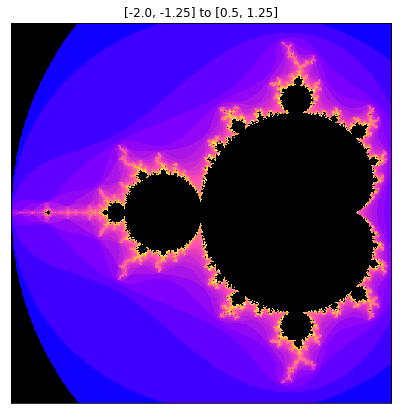

In [6]:
mandelbrot_image(mandel_set1, -2.0, 0.5, -1.25, 1.25)

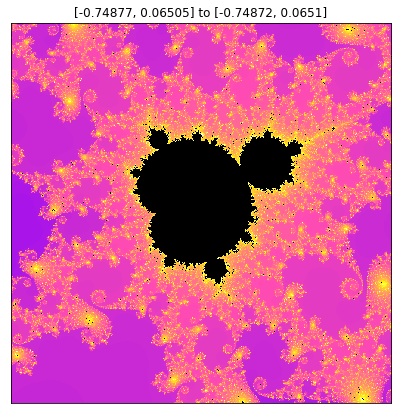

In [7]:
mandelbrot_image(mandel_set1, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

So what is taking so long. Let's profile the code:

In [8]:
p = %prun -r -q mandel_set1()
p.stream = sys.stdout
p.sort_stats('cumulative').print_stats(5)

          25214601 function calls in 12.309 seconds

   Ordered by: cumulative time
   List reduced from 9 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.309   12.309 {built-in method builtins.exec}
        1    0.002    0.002   12.309   12.309 <string>:1(<module>)
        1    0.633    0.633   12.306   12.306 <ipython-input-3-7def9f5d2c07>:13(mandel_set1)
  1000000    9.102    0.000   11.666    0.000 <ipython-input-3-7def9f5d2c07>:5(mandel1)
 24214592    2.564    0.000    2.564    0.000 {built-in method builtins.abs}




Again, the corresponding command line would be

```shell
$ python -m cProfile -s cumulative mandel01.py
```

However, for this to work, the script needs to be executable.

The profile above shows that most of the runtime is spent in the `mandel1` function. Let's get a line-by-line profile of that function

In [9]:
%load_ext line_profiler

In [10]:
p = %lprun -r -f mandel1 mandel_set1()
p.print_stats(sys.stdout)

Timer unit: 1e-06 s

Total time: 39.5987 s
File: <ipython-input-3-7def9f5d2c07>
Function: mandel1 at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def mandel1(c, maxiter):
     6   1000000       415964      0.4      1.1      z = c
     7  24463110     10813255      0.4     27.3      for n in range(maxiter):
     8  24214592     15354524      0.6     38.8          if abs(z) > 2:
     9    751482       336467      0.4      0.8              return n
    10  23463110     12577198      0.5     31.8          z = z*z + c
    11    248518       101297      0.4      0.3      return 0



There is an algorithmic improvement that could be made here: Most of the time in this function is spent on calculating the absolute value and the value of the next iteration. Both of those involve redundant steps that can be factored out. Later on we will implement this, but for now let's try the simplest approach.

## Implementation 2: JIT compiling with numba

[Numba](https://numba.pydata.org/) is a `numpy` aware dynamic Python compiler using LLVM. It can speed up math-heavy, array oriented code with just some minor annotations. At the top of the notebook we imported the `jit` decorator from the numba package. The only modification to the code is decorating the `mandel` function. Note that numba cannot jit compile the current implementation of the `mandel_set` function due to the use of nested lists.

In [11]:
@jit
def mandel2(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = linspace(xmin, xmax, width)
    i = linspace(ymin, ymax, height)
    n = [[0]*width for _ in range(height)]
    for x in range(width):
        for y in range(height):
            n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    return n

In [12]:
%timeit mandel_set2()

1.12 s ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit mandel_set2(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

11.7 s ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


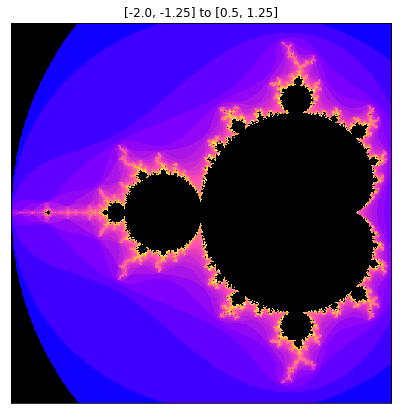

In [14]:
mandelbrot_image(mandel_set2, -2.0, 0.5, -1.25, 1.25)

Now, reprofiling shows that the majority of the remaining runtime is spent in the `mandel_set` function

In [15]:
p = %prun -r -q mandel_set2()
p.stream = sys.stdout
p.sort_stats('cumulative').print_stats()

          1000015 function calls in 2.544 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.544    2.544 {built-in method builtins.exec}
        1    0.002    0.002    2.544    2.544 <string>:1(<module>)
        1    1.876    1.876    2.541    2.541 <ipython-input-11-a5062ceab278>:10(mandel_set2)
  1000000    0.617    0.000    0.617    0.000 <ipython-input-11-a5062ceab278>:1(mandel2)
        1    0.047    0.047    0.047    0.047 <ipython-input-11-a5062ceab278>:13(<listcomp>)
        2    0.000    0.000    0.000    0.000 <ipython-input-3-7def9f5d2c07>:1(linspace)
        2    0.000    0.000    0.000    0.000 <ipython-input-3-7def9f5d2c07>:3(<listcomp>)
        6    0.000    0.000    0.000    0.000 cycler.py:227(<genexpr>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Let's do a line profile on that

In [16]:
p = %lprun -f mandel_set2 -r mandel_set2()
p.print_stats(sys.stdout)

Timer unit: 1e-06 s

Total time: 2.55461 s
File: <ipython-input-11-a5062ceab278>
Function: mandel_set2 at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def mandel_set2(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    11         1          318    318.0      0.0      r = linspace(xmin, xmax, width)
    12         1          290    290.0      0.0      i = linspace(ymin, ymax, height)
    13         1         5623   5623.0      0.2      n = [[0]*width for _ in range(height)]
    14      1001          694      0.7      0.0      for x in range(width):
    15   1001000       683426      0.7     26.8          for y in range(height):
    16   1000000      1864256      1.9     73.0              n[y][x] = mandel2(complex(r[x], i[y]), maxiter)
    17         1            1      1.0      0.0      return n



## Implementation 3: Numpy arrays

[Numpy](http://www.numpy.org/) is the fundamental Python array computation package. Numpy arrays are much more efficient that python lists or arrays. So does changing from lists to numpy arrays in the `mandel_set` function improve performance?

In [17]:
@jit
def mandel3(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandel_set3(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((width,height), dtype=int)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel3(complex(r[x], i[y]), maxiter)
    return n

In [18]:
%timeit mandel_set3()

1.35 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit mandel_set3(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

11.8 s ± 43.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No it did not - it actually is a bit slower. This might change with larger arrays. But either way, now we can jit compile it.

## Implementation 4: Numba jit compile the second function

Again, the only thing that has to change in the code is the `@jit` decorator

In [20]:
@jit
def mandel4(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

@jit
def mandel_set4(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((width,height), dtype=int)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel4(complex(r[x], i[y]), maxiter)
    return n

In [21]:
%timeit mandel_set4()

477 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit mandel_set4(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

11 s ± 79.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ah - that's better. Now the speedup is 16-fold. Note: can't line_profile the jit functions

## Implementation 5: Improve the algorithm

The following are the definition of the square of complex numbers, the absolute value, and the sum of two complex numbers:

$$
\begin{aligned}
(a + bi)^2 &= (a + bi)(a + bi) = (a^2 - b^2) + 2abi \\
|a + bi| &= \sqrt{a^2 + b^2} \\
(a + bi) + (c + di) &= (a + c) + (b + d)i
\end{aligned}
$$

Based on this, we can factor out some redundant calculations by passing the real and imaginary parts of the complex numbers directly to the `mandel` function and calculating their squares separately only once and avoiding the square root computation.

In [23]:
@jit
def mandel5(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return 0

@jit
def mandel_set5(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r = np.linspace(xmin, xmax, width)
    i = np.linspace(ymin, ymax, height)
    n = np.empty((width,height), dtype=int)
    for x in range(width):
        for y in range(height):
            n[y, x] = mandel5(r[x], i[y], maxiter)
    return n

In [24]:
%timeit mandel_set5()

105 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit mandel_set5(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.7 s ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Checking that the results are still correct:

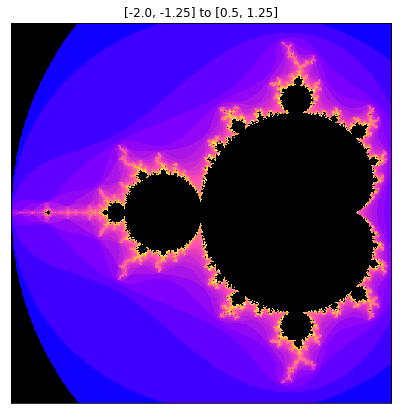

In [26]:
mandelbrot_image(mandel_set5, -2.0, 0.5, -1.25, 1.25)

And drawing the slower slice is much more pleasant now:

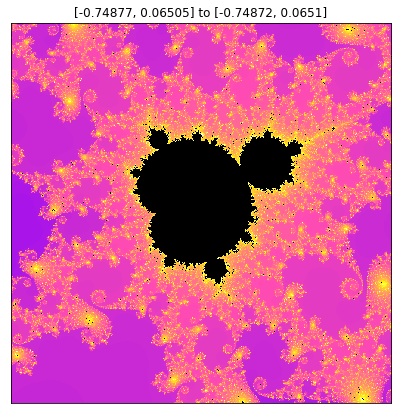

In [27]:
mandelbrot_image(mandel_set5, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

## Implementation 6: Cython

[Cython](http://cython.org/) is a static compiler for Python plus the Cython extensions such as static type definitions. It generates C code that uses the Python C API to create C extensions.

How does a cythonized version of implementation 5 perform? To conveniently use cython code in a jupyter notebook, we'll load the cython extension first. Under the hood, this will generate C code, compile the extension module, and load it.

In [28]:
%load_ext cython

In [29]:
%%cython
import cython
import numpy as np

cdef int mandel6(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandel_set6(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n = np.empty((width,height), np.int32)
        int i,j
    
    for i in range(width):
        for j in range(height):
            n[j,i] = mandel6(r1[i], r2[j], maxiter)
    return n

In [30]:
%timeit mandel_set6(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

104 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit mandel_set6(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.65 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


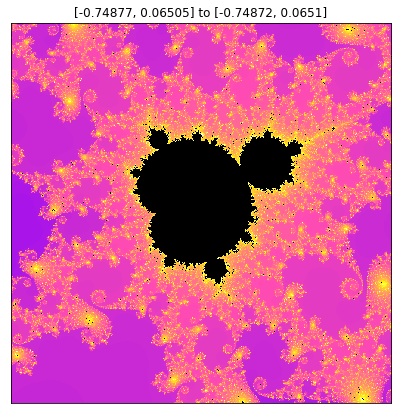

In [32]:
mandelbrot_image(mandel_set6, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

## Implementation 7: GPU with pyopencl

Timing with [pyopencl](https://mathema.tician.de/software/pyopencl/) requires a GPU node and the CUDA module loaded on our systems. The /etc/OpenCL/vendors/ files had to be copied to the corresponding etc dir in the anaconda tree for the pyopencl conda package to recognize the GPU. We're skipping a CPU pyopencl test.

Note that pyopencl is not the only way to offload computation to a GPU. Numba and pycuda are other possibilities.


In [6]:
import pyopencl as cl
platforms = cl.get_platforms()
print(platforms)
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])

[<pyopencl.Platform 'NVIDIA CUDA' at 0x1e841a0>]


In [4]:
def mandel7(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandel_set7(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n = mandel7(c,maxiter)
    n = n.reshape((width,height))
    return n

The timing on this implementation is suddenly off. Not sure why. Might be load on the other GPUs on the system.

In [15]:
%timeit mandel_set7(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

The slowest run took 4.58 times longer than the fastest. This could mean that an intermediate result is being cached.
80.9 ms ± 56.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit mandel_set7(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

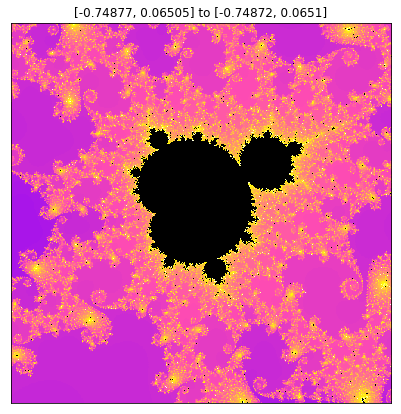

In [10]:
mandelbrot_image(mandel_set7, -0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

## Implementation 8: Fortran

The `f2py` tool included with numpy can be used to bind fortran code to python. I don't have any fortran magic installed, so here is just the fortran code that implements the same algorithm:

In [38]:
%cat mandel08.f90

subroutine mandel_set8(xmin, xmax, ymin, ymax, width, height, itermax, n)
    real(8), intent(in)   :: xmin, xmax, ymin, ymax
    integer, intent(in)   :: width, height, itermax
    integer               :: niter
    integer, dimension(width, height), intent(out) :: n
    integer               :: x, y
    real(8)               :: xstep, ystep
    
    xstep = (xmax - xmin) / (width - 1)
    ystep = (ymax - ymin) / (width - 1)
    do x = 1, width
        do y = 1, height
            call mandel8(xmin + (x - 1) * xstep, ymin + (y - 1) * ystep, itermax, niter)
            n(y, x) = niter
        end do
    end do
end subroutine mandel_set8

subroutine mandel8(cre, cim, itermax, n)
    real(8), intent(in)      :: cre, cim
    integer, intent(in)      :: itermax
    integer, intent(out)     :: n
    real(8)                  :: re2, im2, re, im

    re = cre
    im = cim 
    do n = 0, itermax - 1
        re2 = re ** 2
        im2 = im ** 2
        if (re2 + im2 > 4.0) then
            exit


Which was compiled into the mb_fort module with

```shell
$ f2py -m mb_fort -c mandel8.f90 --fcompiler=gnu95
```

after which it can be imported

In [39]:
from mb_fort import mandel8, mandel_set8

In [40]:
%timeit mandel_set8(-2, 0.5, -1.25, 1.25, 1000, 1000, 80)

107 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit mandel_set8(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

2.68 s ± 33.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


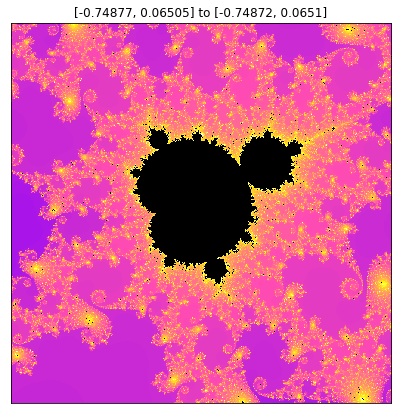

In [42]:
mandelbrot_image(mandel_set8, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048,cmap='gnuplot2')

## Implementation 9: Parallelism on CPU via numba vectorization

Numba provides the `vectorize` and `guvectorize` decorators to create numpy ufuncs that can also be parallelized by using a parallel or GPU backend. Reverting back to passing complex numbers. Note that `guvectorize` does not return a value - it takes an output argument. To benchmark this with different numbers
of threads, I'm saving the file and running in from the shell. Numba uses it's own environment variable to limit paralellism (`NUMBA_NUM_THREADS`). Note that while there is a `numba.config.NUMBA_NUM_THREADS`, setting it does not seem to affect the number of threads used by Numba.

In [43]:
%%writefile mandel09.py
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32
import numpy as np

@jit(int32(complex64, int32))
def mandel9(c,maxiter):
    nreal = 0
    real = 0
    imag = 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal;
        if real * real + imag * imag > 4.0:
            return n
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),()->(n)',target='parallel')
def mandel9v(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        output[i] = mandel9(c[i],maxiter)
        
def mandel_set9(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n = mandel9v(c,maxiter)
    return n

Overwriting mandel09.py


In [44]:
%%bash
expr='mandel09.mandel_set9(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)'
for threads in 1 2 4 8 14; do
    printf "%3i threads\n" ${threads}
    NUMBA_NUM_THREADS=${threads} python -m timeit -s 'import mandel09' "$expr"
done

  1 threads
10 loops, best of 3: 2.74 sec per loop
  2 threads
10 loops, best of 3: 1.54 sec per loop
  4 threads
10 loops, best of 3: 1.07 sec per loop
  8 threads
10 loops, best of 3: 595 msec per loop
 14 threads
10 loops, best of 3: 426 msec per loop


That scales so so. With 1 thread it's about as fast as implementation 5. With 4 threads the efficiency is 63%. With 14 threads it drops to 47%.

## Implementation 10: Multiprocessing

The multiprocessing module emphasizes avoiding shared state, so we'll stick with that.  For simplicity we'll use python lists to begin with to see how good performance is. Since communication has overhead, we'll break the computation up such that each task returns a row.
Note that on linux `fork` is the default way of starting subprocesses. In that case we can get away with not making the main module safely importable. Generally speaking though it's better to do so.

In [47]:
import multiprocessing as mp

ncpus = 1
@jit
def mandel10(creal, cimag, maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2 * real*imag + cimag
        real = real2 - imag2 + creal       
    return 0

@jit
def mandel10_row(args):
    y, xmin, xmax, width, maxiter = args
    r = np.linspace(xmin, xmax, width)
    res = [0] * width
    for x in range(width):
        res[x] = mandel10(r[x], y, maxiter)
    return res
        

def mandel_set10(xmin=-2.0, xmax=0.5, ymin=-1.25, ymax=1.25, width=1000, height=1000, maxiter=80):
    i = np.linspace(ymin, ymax, height)
    with mp.Pool(ncpus) as pool:
        n = pool.map(mandel10_row, ((a, xmin, xmax, width, maxiter) for a in i))
    return n

In [48]:
for i in (1, 2, 4, 8, 14):
    ncpus = i
    %timeit mandel_set10(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

3.26 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.89 s ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.26 s ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
997 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.18 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


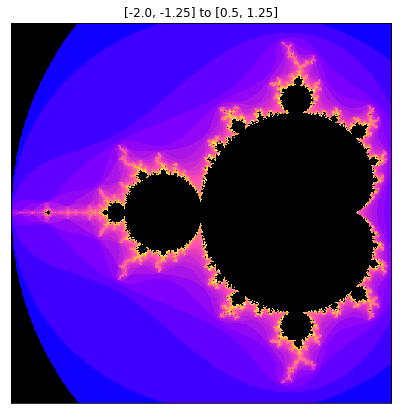

In [49]:
mandelbrot_image(mandel_set10, -2.0, 0.5, -1.25, 1.25)

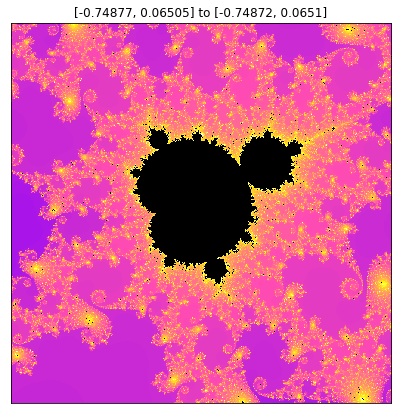

In [50]:
mandelbrot_image(mandel_set10, -0.74877,-0.74872,0.06505,0.06510, maxiter=2048,cmap='gnuplot2')